In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

In [ ]:
https://chat.deepseek.com/a/chat/s/06614676-a05d-49f6-bc43-4c62d17485cf

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("/content/Training_data_uhi_index_UHI2025-v2.csv")
ground_df.head()

Longitude   Latitude          datetime  UHI Index
0 -73.909167  40.813107  24-07-2021 15:53   1.030289
1 -73.909187  40.813045  24-07-2021 15:53   1.030289
2 -73.909215  40.812978  24-07-2021 15:53   1.023798
3 -73.909242  40.812908  24-07-2021 15:53   1.023798
4 -73.909257  40.812845  24-07-2021 15:53   1.021634

In [3]:
import pandas as pd

# Function to load weather data from Excel
def load_weather_data(excel_path):
    # Read the data from both Bronx and Manhattan tabs
    bronx_weather = pd.read_excel(excel_path, sheet_name="Bronx")
    manhattan_weather = pd.read_excel(excel_path, sheet_name="Manhattan")

    # Add latitude, longitude, and station name to each dataset
    bronx_weather['Latitude'] = 40.87248
    bronx_weather['Longitude'] = -73.89352
    bronx_weather['Station'] = 'Bronx'  # Add station name

    manhattan_weather['Latitude'] = 40.76754
    manhattan_weather['Longitude'] = -73.96449
    manhattan_weather['Station'] = 'Manhattan'  # Add station name

    # Combine both datasets
    weather_data = pd.concat([bronx_weather, manhattan_weather], ignore_index=True)

    # Convert 'Date / Time' to datetime format (make sure to remove EDT if present)
    weather_data['Date / Time'] = pd.to_datetime(weather_data['Date / Time'].str.replace(" EDT", ""), format="%Y-%m-%d %H:%M:%S")

    return weather_data

# Define the bounding box for the entire data region using (Latitude, Longitude)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[0], lower_left[1], upper_right[0], upper_right[1])

# Define the time window
time_window = "2021-06-01/2021-09-01"

# Function to filter weather data based on bounding box and time window
def filter_weather_data(weather_data, bounds, time_window):
    # Extract min and max latitude and longitude from bounds
    min_lat, min_lon = bounds[0], bounds[1]
    max_lat, max_lon = bounds[2], bounds[3]

    # Filter based on time window
    start_time, end_time = time_window.split("/")
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    # Filter weather data based on time window
    weather_data = weather_data[(weather_data['Date / Time'] >= start_time) & (weather_data['Date / Time'] <= end_time)]

    # Filter based on location (using the known station locations)
    bronx_location = (40.87248, -73.89352)
    manhattan_location = (40.76754, -73.96449)

    # Check if the stations are within the bounding box
    if (min_lat <= bronx_location[0] <= max_lat) and (min_lon <= bronx_location[1] <= max_lon):
        bronx_data = weather_data[weather_data['Station'] == 'Bronx']
    else:
        bronx_data = pd.DataFrame()

    if (min_lat <= manhattan_location[0] <= max_lat) and (min_lon <= manhattan_location[1] <= max_lon):
        manhattan_data = weather_data[weather_data['Station'] == 'Manhattan']
    else:
        manhattan_data = pd.DataFrame()

    # Combine the filtered data
    filtered_weather_data = pd.concat([bronx_data, manhattan_data], ignore_index=True)

    return filtered_weather_data

# Load weather data
excel_path = '/content/NY_Mesonet_Weather.xlsx'  # Path to the weather data file
weather_data = load_weather_data(excel_path)

# Filter weather data based on bounding box and time window
filtered_weather_data = filter_weather_data(weather_data, bounds, time_window)

# Display the first few rows of the filtered weather data
print(filtered_weather_data.head())

          Date / Time  Air Temp at Surface [degC]  \
0 2021-07-24 06:00:00                        19.3   
1 2021-07-24 06:05:00                        19.4   
2 2021-07-24 06:10:00                        19.3   
3 2021-07-24 06:15:00                        19.4   
4 2021-07-24 06:20:00                        19.4   

   Relative Humidity [percent]  Avg Wind Speed [m/s]  \
0                         88.2                   0.8   
1                         87.9                   0.8   
2                         87.6                   0.7   
3                         87.4                   0.5   
4                         87.0                   0.2   

   Wind Direction [degrees]  Solar Flux [W/m^2]  Latitude  Longitude Station  
0                       335                  12  40.87248  -73.89352   Bronx  
1                       329                  18  40.87248  -73.89352   Bronx  
2                       321                  25  40.87248  -73.89352   Bronx  
3                       307 

In [4]:
import pandas as pd

def merge_weather_with_ground_data(ground_df, weather_data):
    """
    Merge ground data with weather data based on the closest time match.

    Parameters:
        ground_df (pd.DataFrame): Ground data with 'latitude', 'longitude', and 'datetime' columns.
        weather_data (pd.DataFrame): Weather data with 'Date / Time' and other weather details.

    Returns:
        pd.DataFrame: Merged data with weather information.
    """
    # Ensure the datetime columns are in proper datetime format
    ground_df['datetime'] = pd.to_datetime(ground_df['datetime'], format='%d-%m-%Y %H:%M')
    weather_data['Date / Time'] = pd.to_datetime(weather_data['Date / Time'], format='%Y-%m-%d %H:%M:%S')

    # For each row in ground_df, find the closest time match in weather_data
    ground_df['weather_time'] = ground_df['datetime'].apply(lambda x: min(weather_data['Date / Time'], key=lambda t: abs(t - x)))

    # Merge the ground_df with weather data based on closest time match
    merged_df = pd.merge(ground_df, weather_data, left_on='weather_time', right_on='Date / Time', how='left')

    # Drop the additional 'weather_time' and 'Date / Time' columns as they're no longer needed
    merged_df.drop(columns=['weather_time', 'Date / Time'], inplace=True)

    return merged_df

# Example usage assuming 'ground_df' and 'filtered_weather_data' are your DataFrames
merged_data = merge_weather_with_ground_data(ground_df, filtered_weather_data)

# Display the first few rows of the merged dataset
print(merged_data.head())


   Longitude_x  Latitude_x            datetime  UHI Index  \
0   -73.909167   40.813107 2021-07-24 15:53:00   1.030289   
1   -73.909167   40.813107 2021-07-24 15:53:00   1.030289   
2   -73.909187   40.813045 2021-07-24 15:53:00   1.030289   
3   -73.909187   40.813045 2021-07-24 15:53:00   1.030289   
4   -73.909215   40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   2.6                       165                 621   
1                   3.4                       196                 605   
2                   2.6                  

In [5]:
# Rename Latitude_x and Longitude_x to Latitude and Longitude
merged_data = merged_data.rename(columns={
    'Latitude_x': 'Latitude',
    'Longitude_x': 'Longitude'
})

# Drop unnecessary columns
columns_to_drop = ['Latitude_y', 'Longitude_y']
merged_data = merged_data.drop(columns=columns_to_drop)

# Display the first few rows of the cleaned dataset
print(merged_data.head())

   Longitude   Latitude            datetime  UHI Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   2.6                       165                 621   
1                   3.4                       196                 605   
2                   2.6                       165          

In [6]:
merged_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'Station'],
      dtype='object')

In [7]:
import numpy as np

# Assuming the datetime column is already in datetime format in merged_data
merged_data['datetime'] = pd.to_datetime(merged_data['datetime'])

# Extract useful time-related features
merged_data['year'] = merged_data['datetime'].dt.year
merged_data['month'] = merged_data['datetime'].dt.month
merged_data['day'] = merged_data['datetime'].dt.day
merged_data['day_of_year'] = merged_data['datetime'].dt.dayofyear
merged_data['hour'] = merged_data['datetime'].dt.hour
merged_data['weekday'] = merged_data['datetime'].dt.weekday

# Optional: Create a feature for weekends (1 if weekend, 0 if weekday)
merged_data['is_weekend'] = merged_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Cyclic Transformation for 'hour', 'day_of_year', 'month' in merged_data
merged_data['hour_sin'] = np.sin(2 * np.pi * merged_data['hour'] / 24)
merged_data['hour_cos'] = np.cos(2 * np.pi * merged_data['hour'] / 24)

merged_data['day_sin'] = np.sin(2 * np.pi * merged_data['day_of_year'] / 365)
merged_data['day_cos'] = np.cos(2 * np.pi * merged_data['day_of_year'] / 365)

merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['month'] / 12)
merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['month'] / 12)

# After cyclic transformation, drop the original columns
merged_data = merged_data.drop(columns=['hour', 'day_of_year', 'month'])

# Display the first few rows of the merged data with new time-related features
print(merged_data.head())


   Longitude   Latitude            datetime  UHI Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   2.6                       165                 621   
1                   3.4                       196                 605   
2                   2.6                       165          

In [8]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

In [9]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [10]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [11]:
# Define the time window
time_window = "2021-06-01/2021-09-01"

In [12]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [13]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 10


In [14]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [15]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [16]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [17]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data)

<xarray.Dataset> Size: 532MB
Dimensions:      (latitude: 1448, longitude: 1671, time: 10)
Coordinates:
  * latitude     (latitude) float64 12kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 13kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 80B 2021-06-06T15:38:09.024000 ... 202...
Data variables:
    B01          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B02          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B05          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B06          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B07          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B08          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B11          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>
    B12          (time, latitude, longitude) uint16 48MB dask.array<chunksize=(1, 1448, 1671), meta=np.ndarray>

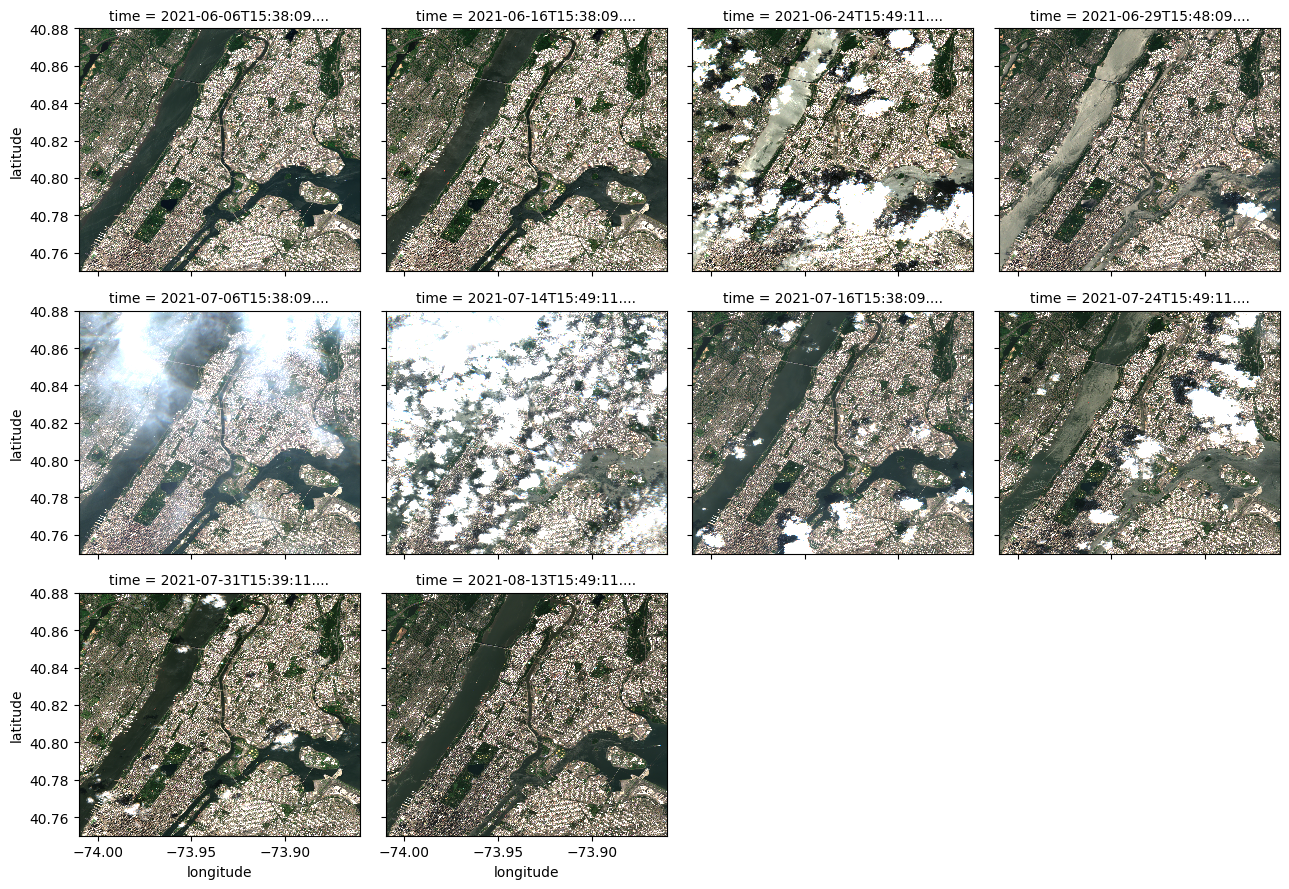

In [18]:
# Plot sample images from the time series
plot_data = data[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

In [19]:
filename = "S2_sample.tiff"

In [20]:
# We will pick a single time slice from the time series (time=7)
# This time slice is the date of July 24, 2021
data_slice = data.isel(time=7)

In [21]:
# Calculate the dimensions of the file
# height = median.dims["latitude"]
# width = median.dims["longitude"]
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]

In [22]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);

In [23]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=4,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B01,1)
    dst.write(data_slice.B04,2)
    dst.write(data_slice.B06,3)
    dst.write(data_slice.B08,4)
    dst.close()

In [24]:
# Show the location and size of the new output file
!ls *.tiff

S2_sample.tiff


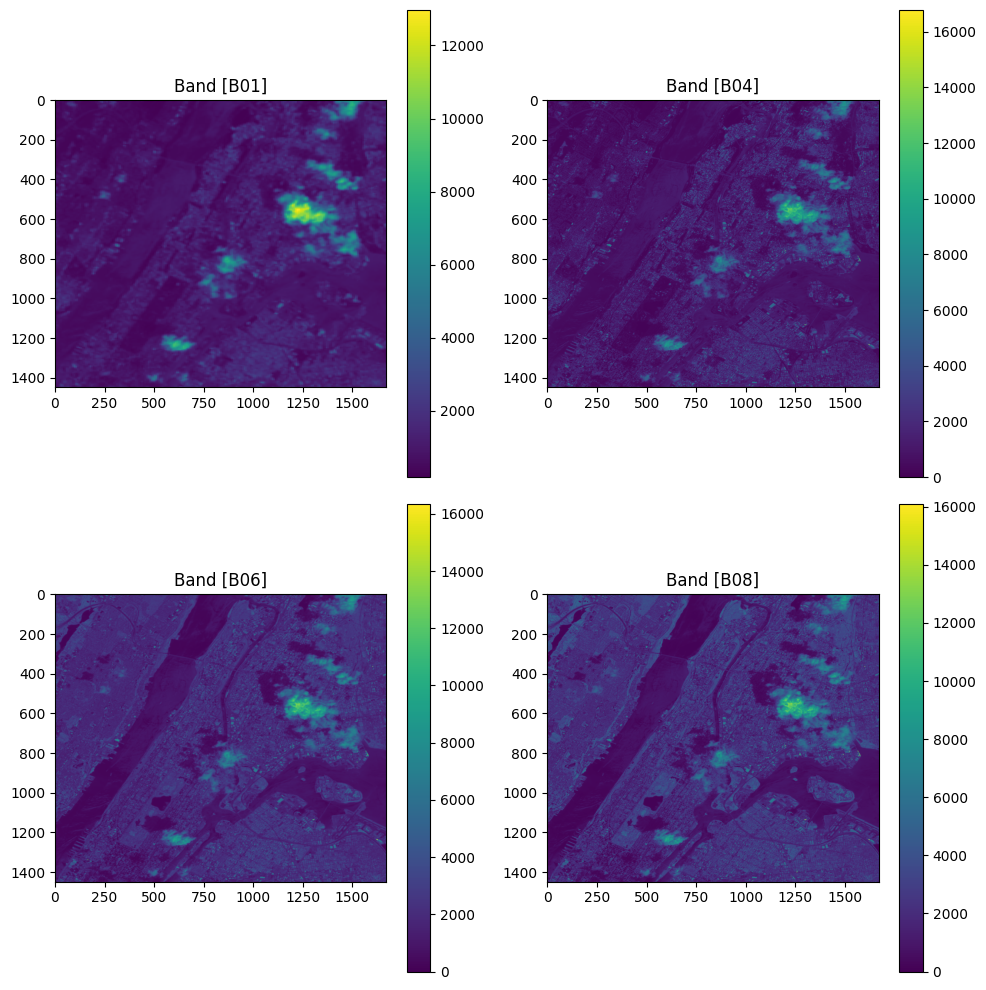

In [25]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


**Landsat_LST Data**

In [26]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

In [27]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [28]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [29]:
# Define the time window
# We will use a period of 3 months to search for data
time_window = "2021-06-01/2021-09-01"

In [30]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 50},"platform": {"in": ["landsat-8"]}},
)

In [31]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))

This is the number of scenes that touch our region: 8


In [32]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [33]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 30  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [34]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [35]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [36]:
# View the dimensions of our XARRAY and the loaded variables
# This insures we have the right coordinates and spectral bands in our xarray
display(data1)
display(data2)

<xarray.Dataset> Size: 17MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    red          (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    green        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    blue         (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>
    nir08        (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

<xarray.Dataset> Size: 4MB
Dimensions:      (latitude: 484, longitude: 558, time: 8)
Coordinates:
  * latitude     (latitude) float64 4kB 40.88 40.88 40.88 ... 40.75 40.75 40.75
  * longitude    (longitude) float64 4kB -74.01 -74.01 -74.01 ... -73.86 -73.86
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 64B 2021-06-07T15:39:15.904901 ... 202...
Data variables:
    lwir11       (time, latitude, longitude) uint16 4MB dask.array<chunksize=(1, 484, 558), meta=np.ndarray>

In [37]:
# Persist the data in memory for faster operations
data1 = data1.persist()
data2 = data2.persist()

In [38]:
# Scale Factors for the RGB and NIR bands
scale1 = 0.0000275
offset1 = -0.2
data1 = data1.astype(float) * scale1 + offset1

In [39]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

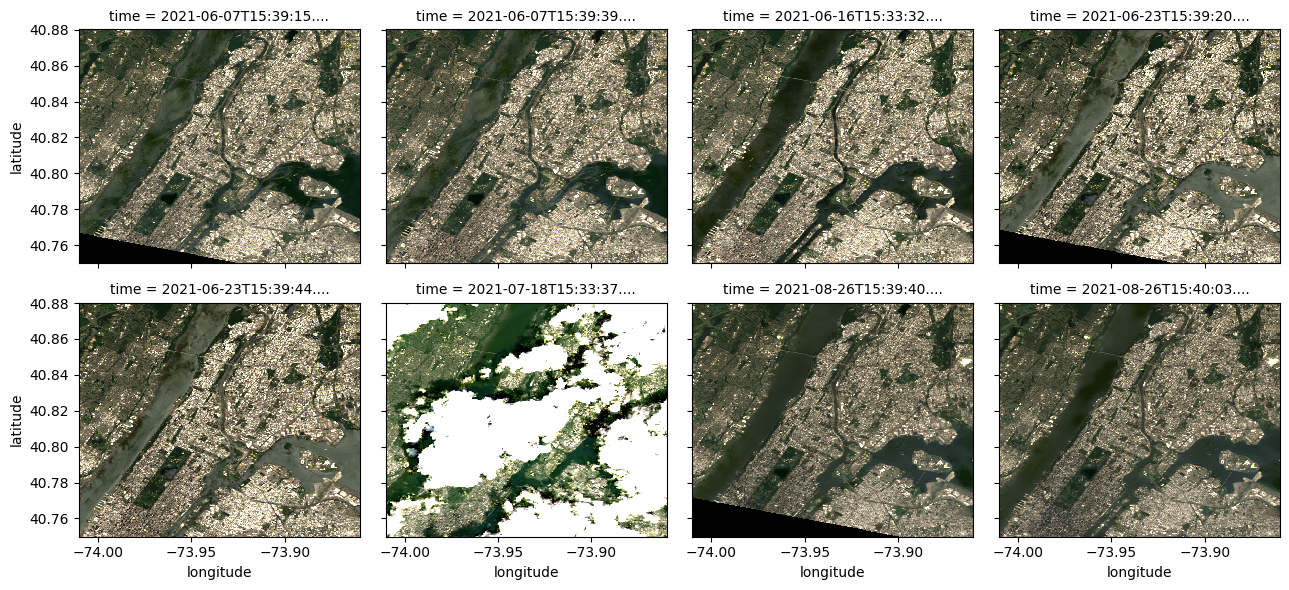

In [40]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

In [41]:
# Pick one of the scenes above (numbering starts with 0)
scene = 2

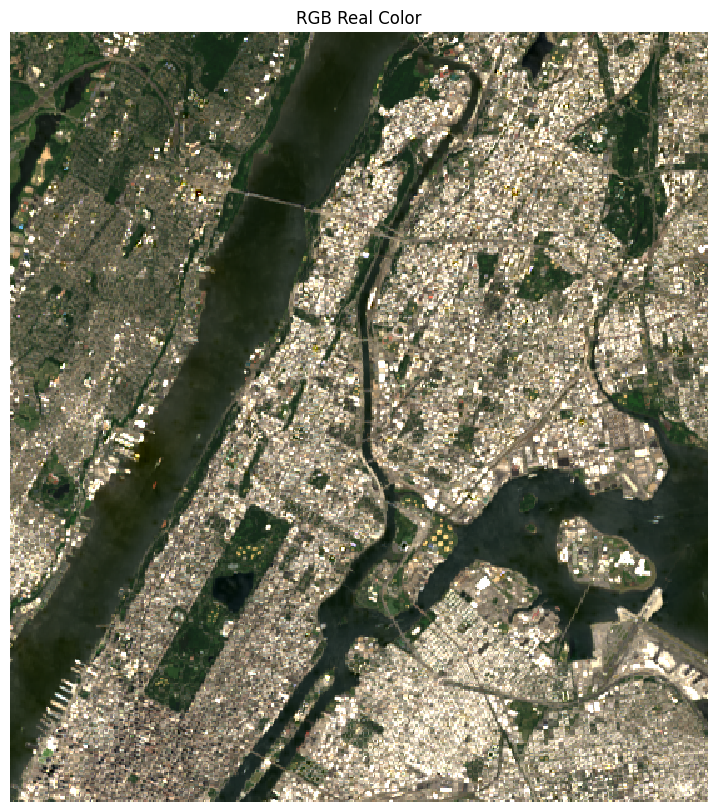

In [42]:
# Plot an RGB Real Color Image for a single date
fig, ax = plt.subplots(figsize=(9,10))
data1.isel(time=scene)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Real Color")
ax.axis('off')
plt.show()

In [43]:
# Calculate NDVI for the median mosaic
ndvi_data = (data1.isel(time=scene).nir08-data1.isel(time=scene).red)/(data1.isel(time=scene).nir08+data1.isel(time=scene).red)

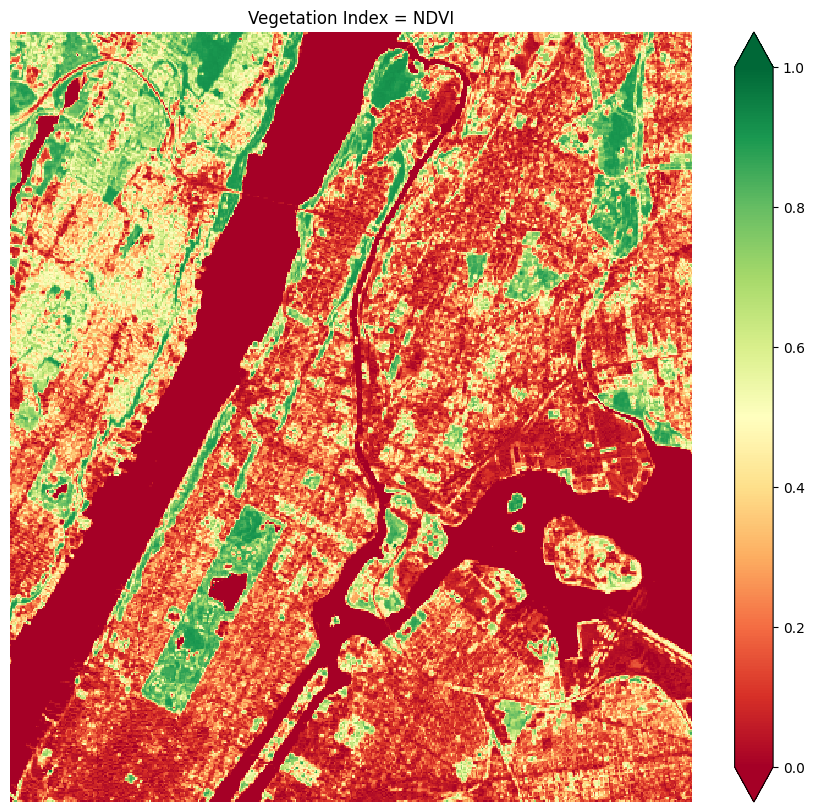

In [44]:
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

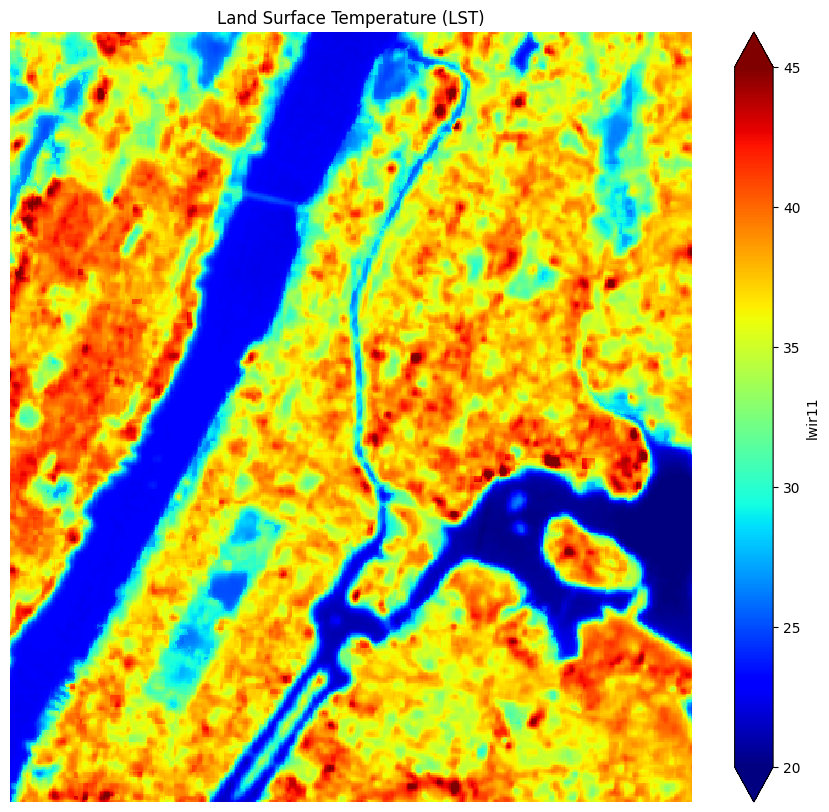

In [45]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

In [46]:
# Only select one of the time slices to output
data3 = data2.isel(time=scene)

In [47]:
filename = "Landsat_LST.tiff"

In [48]:
# Calculate the dimensions of the file
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [49]:
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);

In [50]:
# Create the GeoTIFF output file using the defined parameters
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(data3.lwir11,1)
    dst.close()

In [51]:
# Show the new saved output file
!ls *.tiff

Landsat_LST.tiff  S2_sample.tiff


In [52]:
import rasterio
import numpy as np
import pandas as pd

# Assuming the file is uploaded and is now in the current working directory
filename = "Landsat_LST.tiff"  # Replace with the correct filename if different

# Open the TIFF file using rasterio
with rasterio.open(filename) as dataset:
    # Read the data into a numpy array
    data = dataset.read(1)  # Read the first band (assuming single band)

# Flatten the 2D array into 1D and create a DataFrame
data_flat = data.flatten()
df = pd.DataFrame(data_flat, columns=['LST'])

# Optionally, add row and column coordinates for each pixel
cols, rows = np.meshgrid(range(data.shape[1]), range(data.shape[0]))
coords = np.stack((rows.flatten(), cols.flatten()), axis=-1)
df[['row', 'col']] = coords

# Display the DataFrame
df.head()

LST  row  col
0  38.045303    0    0
1  37.289921    0    1
2  36.777218    0    2
3  36.777218    0    3
4  36.972045    0    4

In [53]:
import pandas as pd
import rioxarray as rxr
from pyproj import Proj, Transformer
from tqdm import tqdm

def map_satellite_data_with_lst(tiff_path, lst_path, merged_data):
    # Load the GeoTIFF data for the satellite bands
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Load the Landsat LST data
    lst_data = rxr.open_rasterio(lst_path)
    lst_crs = lst_data.rio.crs

    # Extract latitudes and longitudes from merged_data
    latitudes = merged_data['Latitude'].values
    longitudes = merged_data['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 (WGS84 - lat/long)
    proj_tiff = Proj(tiff_crs)
    proj_lst = Proj(lst_crs)

    # Create transformer objects for both datasets
    transformer_tiff = Transformer.from_proj(proj_wgs84, proj_tiff)
    transformer_lst = Transformer.from_proj(proj_wgs84, proj_lst)

    # Initialize lists to store the band values
    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    LST_values = []

    # Iterate over latitudes and longitudes to extract the values for each band and LST
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Extract band values
        B01_value = data.sel(x=lon, y=lat, band=1, method="nearest").values
        B01_values.append(B01_value)

        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)

        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)

        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        LST_value = lst_data.sel(x=lon, y=lat, method="nearest").values.item()
        LST_values.append(LST_value)

    # Create the final DataFrame with all the values
    df_final = pd.DataFrame()
    df_final['B01'] = B01_values
    df_final['B04'] = B04_values
    df_final['B06'] = B06_values
    df_final['B08'] = B08_values
    df_final['LST'] = LST_values

    # Merge the final data with the merged_data (assuming merged_data has Latitude and Longitude)
    df_final = pd.concat([merged_data, df_final], axis=1)

    return df_final

# Assuming merged_data already contains Latitude and Longitude columns and other features
final_data_with_lst = map_satellite_data_with_lst('S2_sample.tiff', 'Landsat_LST.tiff', merged_data)

# Display the final DataFrame with the satellite data and merged data
print(final_data_with_lst.head())


Mapping values: 100%|██████████| 22458/22458 [02:32<00:00, 146.97it/s]

   Longitude   Latitude            datetime  UHI Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   2.6                       165                 621   
1                   3.4                       196                 605   
2                   2.6                       165          

In [54]:
final_data_with_lst.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'Station', 'year', 'day', 'weekday', 'is_weekend',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'B01', 'B04', 'B06', 'B08', 'LST'],
      dtype='object')

In [55]:
import pandas as pd
import rioxarray as rxr
from pyproj import Proj, Transformer
from tqdm import tqdm

In [56]:
# Make a copy of final_data_with_lst to uhi_data
uhi_data = final_data_with_lst.copy()

# Display the first few rows of uhi_data
print(uhi_data.head())

   Longitude   Latitude            datetime  UHI Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   2.6                       165                 621   
1                   3.4                       196                 605   
2                   2.6                       165          

In [57]:
# Create NDVI, NDBI, EVI with handling division by zero
def calculate_ndvi(b08, b04):
    denominator = b08 + b04
    return (b08 - b04) / denominator if denominator != 0 else 0

def calculate_ndbi(b06, b08):
    denominator = b06 + b08
    return (b06 - b08) / denominator if denominator != 0 else 0

def calculate_evi(b08, b04, b01):
    denominator = b08 + 6 * b04 - 7.5 * b01 + 1
    return 2.5 * ((b08 - b04) / denominator) if denominator != 0 else 0

uhi_data['NDVI'] = uhi_data.apply(lambda row: calculate_ndvi(row['B08'], row['B04']), axis=1)
uhi_data['NDBI'] = uhi_data.apply(lambda row: calculate_ndbi(row['B06'], row['B08']), axis=1)
uhi_data['EVI'] = uhi_data.apply(lambda row: calculate_evi(row['B08'], row['B04'], row['B01']), axis=1)

In [58]:
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'Station', 'year', 'day', 'weekday', 'is_weekend',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'B01', 'B04', 'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI'],
      dtype='object')

In [ ]:
features = ['Longitude', 'Latitude', 'datetime', 'UHI Index',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'Station', 'year', 'day', 'weekday', 'is_weekend',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'B01', 'B04', 'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI']

# Remove duplicate rows based on the specified columns (excluding Longitude and Latitude)
columns_to_check = ['B01', 'B04', 'B06', 'B08', 'NDVI', 'LST']  # Excluding Longitude and Latitude here
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
#uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')

# Resetting the index of the dataset
uhi_data = uhi_data.reset_index(drop=True)

In [ ]:
uhi_data.head()

Longitude   Latitude            datetime  UHI Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  year  \
0                   2.6                       165                 621  2021   
1                   3.4                       196                 605  2021   
2                   2.6                       165                 621  2021   
3                   3.4                       196                 605  2021   
4                   2.6                       165                 621  2021   

   ...  month_sin  month_cos    B01     B04     B06     B08        LST  \
0  ...       -0.5  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941   
1  ...       -0.5  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941   
2  ...       -0.5  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941   
3  ...       -0.5  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941   
4  ...       -0.5  -0.866025  846.0   709.0  1668.0  2190.0  37.785534   

       NDVI      NDBI        EVI  
0  0.295717 -0.118545   1.223285  
1  0.295717 -0.118545   1.223285  
2  0.295717 -0.118545   1.223285  
3  0.295717 -0.118545   1.223285  
4  0.510866 -0.135303  37.025000  

[5 rows x 27 columns]

In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# 1. **One-Hot Encoding for 'month', 'weekday', 'is_weekend'**
uhi_data = pd.get_dummies(uhi_data, columns=['weekday', 'is_weekend','Station'], drop_first=True)  # Drop 'first' to avoid multicollinearity

# Drop the original features since they are transformed
#uhi_data = uhi_data.drop(columns=['year','day'])

# Now you can scale the numeric columns (e.g., 'B01', 'B04', etc.) using StandardScaler
#scaler = StandardScaler()
#columns_to_scale = ['B01', 'B04', 'B06', 'B08', 'NDVI', 'NDBI', 'EVI', 'LST']  # Add the columns you want to scale
#uhi_data[columns_to_scale] = scaler.fit_transform(uhi_data[columns_to_scale])
uhi_data.head()

Longitude   Latitude            datetime  UHI Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        27.2                         47.3   
1                        26.8                         46.7   
2                        27.2                         47.3   
3                        26.8                         46.7   
4                        27.2                         47.3   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  year  \
0                   2.6                       165                 621  2021   
1                   3.4                       196                 605  2021   
2                   2.6                       165                 621  2021   
3                   3.4                       196                 605  2021   
4                   2.6                       165                 621  2021   

   ...  month_cos    B01     B04     B06     B08        LST      NDVI  \
0  ...  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941  0.295717   
1  ...  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941  0.295717   
2  ...  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941  0.295717   
3  ...  -0.866025  846.0  1036.0  1502.0  1906.0  38.393941  0.295717   
4  ...  -0.866025  846.0   709.0  1668.0  2190.0  37.785534  0.510866   

       NDBI        EVI Station_Manhattan  
0 -0.118545   1.223285             False  
1 -0.118545   1.223285              True  
2 -0.118545   1.223285             False  
3 -0.118545   1.223285              True  
4 -0.135303  37.025000             False  

[5 rows x 26 columns]

In [60]:
uhi_data = uhi_data.reset_index(drop=True)

In [61]:
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index',
       'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'year', 'day', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'B01', 'B04', 'B06', 'B08', 'LST',
       'NDVI', 'NDBI', 'EVI', 'Station_Manhattan'],
      dtype='object')

In [62]:
# Drop the original features since they are transformed
uhi_data = uhi_data.drop(columns=['year','day'])

In [93]:
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

In [94]:
uhi_data = clean_column_names(uhi_data)
uhi_data.columns

Index(['Longitude', 'Latitude', 'datetime', 'UHI_Index',
       'Air_Temp_at_Surface_degC', 'Relative_Humidity_percent',
       'Avg_Wind_Speed_ms', 'Wind_Direction_degrees', 'Solar_Flux_Wm2',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'B01', 'B04', 'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI',
       'Station_Manhattan'],
      dtype='object')

In [95]:
features = ['Air_Temp_at_Surface_degC', 'Relative_Humidity_percent',
       'Avg_Wind_Speed_ms', 'Wind_Direction_degrees', 'Solar_Flux_Wm2',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'B01', 'B04', 'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI']

In [97]:
uhi_data.head()

Longitude   Latitude            datetime  UHI_Index  \
0 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
1 -73.909167  40.813107 2021-07-24 15:53:00   1.030289   
2 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
3 -73.909187  40.813045 2021-07-24 15:53:00   1.030289   
4 -73.909215  40.812978 2021-07-24 15:53:00   1.023798   

   Air_Temp_at_Surface_degC  Relative_Humidity_percent  Avg_Wind_Speed_ms  \
0                      27.2                       47.3                2.6   
1                      26.8                       46.7                3.4   
2                      27.2                       47.3                2.6   
3                      26.8                       46.7                3.4   
4                      27.2                       47.3                2.6   

   Wind_Direction_degrees  Solar_Flux_Wm2  hour_sin  ...  month_cos    B01  \
0                     165             621 -0.707107  ...  -0.866025  846.0   
1                     196             605 -0.707107  ...  -0.866025  846.0   
2                     165             621 -0.707107  ...  -0.866025  846.0   
3                     196             605 -0.707107  ...  -0.866025  846.0   
4                     165             621 -0.707107  ...  -0.866025  846.0   

      B04     B06     B08        LST      NDVI      NDBI        EVI  \
0  1036.0  1502.0  1906.0  38.393941  0.295717 -0.118545   1.223285   
1  1036.0  1502.0  1906.0  38.393941  0.295717 -0.118545   1.223285   
2  1036.0  1502.0  1906.0  38.393941  0.295717 -0.118545   1.223285   
3  1036.0  1502.0  1906.0  38.393941  0.295717 -0.118545   1.223285   
4   709.0  1668.0  2190.0  37.785534  0.510866 -0.135303  37.025000   

   Station_Manhattan  
0              False  
1               True  
2              False  
3               True  
4              False  

[5 rows x 24 columns]

In [99]:
# Split the data into features (X) and target (y)
X = uhi_data[features].values
y = uhi_data['UHI_Index'].values  # Use 'UHI_Index' instead of 'UHI Index'

# Now, split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Optionally, you can check the resulting dataset
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (15720, 19)
Testing set size: (6738, 19)


In [100]:
# Scale the training and test data using standardscaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [101]:
# Clamp extreme values
X_train = np.clip(X_train, -1e6, 1e6)
X_test = np.clip(X_test, -1e6, 1e6)

In [74]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Best hyperparameters found
best_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 4,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0
}

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the model using the best parameters
model = xgb.train(best_params, dtrain, num_boost_round=best_params['n_estimators'])

# Make predictions on the test set
y_pred_xgb = model.predict(dtest)

# Model Evaluation
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print the results
print("\nXGBoost Regressor Model (using best parameters)")
print(f"Out Sample R-squared: {r2_xgb}")


XGBoost Regressor Model (using best parameters)
Out Sample R-squared: 0.8289720655795242


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
import xgboost as xgb

# Create a dictionary of models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)
}

# Perform cross-validation and calculate R^2 scores for each model
results = {}
for name, model in models.items():
    # Using negative R-squared as the scoring parameter because sklearn's cross_val_score maximizes scores
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(r2_score))
    results[name] = score.mean()

# Display the results
print("Model comparison based on cross-validation R^2 scores:")
for name, score in results.items():
    print(f"{name}: {score:.4f}")


Model comparison based on cross-validation R^2 scores:
Linear Regression: 0.1379
Random Forest: 0.7831
SVR: -0.0037
Gradient Boosting: 0.3091
XGBoost: 0.7140


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the model (example using XGBoost)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the tuned model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate R^2 score
r2_best_model = r2_score(y_test, y_pred)
print(f"Out Sample R-squared (best model after tuning): {r2_best_model:.4f}")


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best hyperparameters found by GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Out Sample R-squared (best model after tuning): 0.8340


In [102]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Assuming X and y are your feature and target datasets
# X = your_features_dataframe
# y = your_target_column

# Best hyperparameters found via GridSearchCV
best_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,  # Best hyperparameter found by GridSearchCV
    'subsample': 0.8,       # Best hyperparameter found by GridSearchCV
    'colsample_bytree': 1.0,
    'gamma': 0
}

# Create DMatrix for XGBoost (this is a data format that XGBoost works with)
dtrain = xgb.DMatrix(X, label=y)  # Training data
dtest = xgb.DMatrix(X, label=y)   # Test data (same dataset for demonstration)

# Train the model using the best parameters found
model = xgb.train(best_params, dtrain, num_boost_round=best_params['n_estimators'])

# Make predictions on the training set
y_pred_train = model.predict(dtrain)

# Model Evaluation - R² score on training data
r2_train = r2_score(y, y_pred_train)

# Make predictions on the test set
y_pred_test = model.predict(dtest)

# Model Evaluation - R² score on test data
r2_test = r2_score(y, y_pred_test)

# Print the results
print("\nXGBoost Regressor Model (using best parameters)")
print(f"Training R-squared: {r2_train:.4f}")
print(f"Test R-squared: {r2_test:.4f}")



XGBoost Regressor Model (using best parameters)
Training R-squared: 0.9440
Test R-squared: 0.9440


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import scipy

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': scipy.stats.randint(100, 500),
    'learning_rate': scipy.stats.uniform(0.01, 0.1),
    'max_depth': [3, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Perform RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=50, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1, random_state=42)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Best hyperparameters found by RandomizedSearchCV
print("Best hyperparameters found by RandomizedSearchCV:")
print(random_search.best_params_)

# Evaluate the tuned model on the test set
best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_test)

# Calculate R^2 score
r2_best_model_random = r2_score(y_test, y_pred_random)
print(f"Out Sample R-squared (best model after random search tuning): {r2_best_model_random:.4f}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters found by RandomizedSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': np.float64(0.09583588048137198), 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 445, 'subsample': 0.8}
Out Sample R-squared (best model after random search tuning): 0.8166


In [75]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=fba5c1a2cabfd96fb2b7b5567b1f318ca1487a3487c50726faa72f32bad3e8e1
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o


In [76]:
import h2o
from h2o.automl import H2OAutoML

# Initialize the H2O cluster
h2o.init()

# Convert your dataset (Assuming uhi_data is the dataframe you want to use)
# Make sure the target column is categorical or numeric based on your problem type
h2o_data = h2o.H2OFrame(uhi_data)

# Specify the target and feature columns
target = 'UHI Index'  # Update with your target column name
features = [
    'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'B01', 'B04', 'B06', 'B08', 'LST',
       'NDVI', 'NDBI', 'EVI'
]

# Split the data into train and test sets
train, test = h2o_data.split_frame(ratios=[.8], seed=42)

# Run H2O AutoML
aml = H2OAutoML(max_models=20, seed=42, max_runtime_secs=3600)  # You can set max_models or time limit
aml.train(x=features, y=target, training_frame=train)

# Get the leaderboard of models
leaderboard = aml.leaderboard
print(leaderboard)

# Get the best model
best_model = aml.leader

# Evaluate the model performance on the test set
performance = best_model.model_performance(test_data=test)
print(performance)

# Calculate R² score
r2_best_model = performance.r2()
print(f"Out Sample R-squared (best model after tuning): {r2_best_model:.4f}")

# Make predictions with the best model
predictions = best_model.predict(test)
print(predictions.head())

# If you want to save the model:
best_model.save_mojo('best_model.zip')

# Shutdown H2O cluster (optional)
#h2o.shutdown()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphcfh7qg4
  JVM stdout: /tmp/tmphcfh7qg4/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphcfh7qg4/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    4 months and 15 days
H2O_cluster_name:           H2O_from_python_unknownUser_46vh4s
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
12:44:07.365: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, day_cos]

████
12:46:50.880: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, day_cos]


12:46:53.623: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, day_cos]

████
12:50:25.889: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, day_cos]

██
12:52:52.157: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, day_cos]

█
12:53:42.113: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, day_cos]

██
12:55:50.468: _train param, Dropping bad and constant columns: [month_sin, month_cos, hour_cos, hour_sin, day_sin, da

'/content/best_model.zip/GBM_4_AutoML_1_20250317_124407.zip'

In [105]:
test_data = pd.read_csv('/content/Submission_template_UHI2025-v2.csv')
test_data.head()

Longitude   Latitude  UHI Index
0 -73.971665  40.788763        NaN
1 -73.971928  40.788875        NaN
2 -73.967080  40.789080        NaN
3 -73.972550  40.789082        NaN
4 -73.969697  40.787953        NaN

In [106]:
import pandas as pd

# Function to load weather data from Excel
def load_weather_data(excel_path):
    # Read the data from both Bronx and Manhattan tabs
    bronx_weather = pd.read_excel(excel_path, sheet_name="Bronx")
    manhattan_weather = pd.read_excel(excel_path, sheet_name="Manhattan")

    # Add latitude, longitude, and station name to each dataset
    bronx_weather['Latitude'] = 40.87248
    bronx_weather['Longitude'] = -73.89352
    bronx_weather['Station'] = 'Bronx'  # Add station name

    manhattan_weather['Latitude'] = 40.76754
    manhattan_weather['Longitude'] = -73.96449
    manhattan_weather['Station'] = 'Manhattan'  # Add station name

    # Combine both datasets
    weather_data = pd.concat([bronx_weather, manhattan_weather], ignore_index=True)

    # Convert 'Date / Time' to datetime format (make sure to remove EDT if present)
    weather_data['Date / Time'] = pd.to_datetime(weather_data['Date / Time'].str.replace(" EDT", ""), format="%Y-%m-%d %H:%M:%S")

    return weather_data

# Define the bounding box for the entire data region using (Latitude, Longitude)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[0], lower_left[1], upper_right[0], upper_right[1])

# Define the time window
time_window = "2021-06-01/2021-09-01"

# Function to filter weather data based on bounding box and time window
def filter_weather_data(weather_data, bounds, time_window):
    # Extract min and max latitude and longitude from bounds
    min_lat, min_lon = bounds[0], bounds[1]
    max_lat, max_lon = bounds[2], bounds[3]

    # Filter based on time window
    start_time, end_time = time_window.split("/")
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)

    # Filter weather data based on time window
    weather_data = weather_data[(weather_data['Date / Time'] >= start_time) & (weather_data['Date / Time'] <= end_time)]

    # Filter based on location (using the known station locations)
    bronx_location = (40.87248, -73.89352)
    manhattan_location = (40.76754, -73.96449)

    # Check if the stations are within the bounding box
    if (min_lat <= bronx_location[0] <= max_lat) and (min_lon <= bronx_location[1] <= max_lon):
        bronx_data = weather_data[weather_data['Station'] == 'Bronx']
    else:
        bronx_data = pd.DataFrame()

    if (min_lat <= manhattan_location[0] <= max_lat) and (min_lon <= manhattan_location[1] <= max_lon):
        manhattan_data = weather_data[weather_data['Station'] == 'Manhattan']
    else:
        manhattan_data = pd.DataFrame()

    # Combine the filtered data
    filtered_weather_data = pd.concat([bronx_data, manhattan_data], ignore_index=True)

    return filtered_weather_data

# Function to merge weather data with submission data based on time proximity
def merge_weather_with_submission_data(submission_data, weather_data):
    # If submission data does not have a datetime column, assume a default timestamp
    if 'datetime' not in submission_data.columns:
        # Assign a default timestamp (e.g., the middle of the time window)
        submission_data['datetime'] = pd.to_datetime("2021-07-15 12:00:00")  # Adjust as needed

    # For each row in submission data, find the closest time match in weather data
    submission_data['weather_time'] = submission_data['datetime'].apply(lambda x: min(weather_data['Date / Time'], key=lambda t: abs(t - x)))

    # Merge the submission data with weather data based on closest time match
    merged_data = pd.merge(submission_data, weather_data, left_on='weather_time', right_on='Date / Time', how='left')

    # Drop the additional weather_time column, as it's no longer needed
    merged_data.drop(columns=['weather_time'], inplace=True)

    return merged_data

# Load weather data
excel_path = '/content/NY_Mesonet_Weather.xlsx'  # Path to the weather data file
weather_data = load_weather_data(excel_path)

# Filter weather data based on bounding box and time window
filtered_weather_data = filter_weather_data(weather_data, bounds, time_window)

# Load submission data (replace this with your actual submission file)
submission_data = pd.read_csv('/content/Submission_template_UHI2025-v2.csv')  # Adjust path to your submission file

# Ensure the submission data has the required columns
if not {'Longitude', 'Latitude', 'UHI Index'}.issubset(submission_data.columns):
    raise ValueError("Submission file must contain 'Longitude', 'Latitude', and 'UHI Index' columns.")

# Merge weather data with submission data
final_submission_data_with_weather = merge_weather_with_submission_data(submission_data, filtered_weather_data)

# Rename Latitude_x and Longitude_x to Latitude and Longitude
final_submission_data_with_weather = final_submission_data_with_weather.rename(columns={
    'Latitude_x': 'Latitude',
    'Longitude_x': 'Longitude'
})

final_submission_data_with_weather.head()

Longitude   Latitude  UHI Index            datetime         Date / Time  \
0 -73.971665  40.788763        NaN 2021-07-15 12:00:00 2021-07-24 06:00:00   
1 -73.971665  40.788763        NaN 2021-07-15 12:00:00 2021-07-24 06:00:00   
2 -73.971928  40.788875        NaN 2021-07-15 12:00:00 2021-07-24 06:00:00   
3 -73.971928  40.788875        NaN 2021-07-15 12:00:00 2021-07-24 06:00:00   
4 -73.967080  40.789080        NaN 2021-07-15 12:00:00 2021-07-24 06:00:00   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        19.3                         88.2   
1                        21.3                         66.5   
2                        19.3                         88.2   
3                        21.3                         66.5   
4                        19.3                         88.2   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                   0.8                       335                  12   
1                   0.9                       348                  10   
2                   0.8                       335                  12   
3                   0.9                       348                  10   
4                   0.8                       335                  12   

   Latitude_y  Longitude_y    Station  
0    40.87248    -73.89352      Bronx  
1    40.76754    -73.96449  Manhattan  
2    40.87248    -73.89352      Bronx  
3    40.76754    -73.96449  Manhattan  
4    40.87248    -73.89352      Bronx

In [109]:
# Drop unnecessary columns
#columns_to_drop = ['Station', 'datetime', 'Latitude_y', 'Longitude_y','datetime']
#final_submission_data_with_weather = final_submission_data_with_weather.drop(columns=columns_to_drop)

final_submission_data_with_weather = final_submission_data_with_weather.rename(columns={
    'Date / Time': 'datetime'
})


print(final_submission_data_with_weather.head())

   Longitude   Latitude  UHI Index            datetime  \
0 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
1 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
2 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
3 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
4 -73.967080  40.789080        NaN 2021-07-24 06:00:00   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        19.3                         88.2   
1                        21.3                         66.5   
2                        19.3                         88.2   
3                        21.3                         66.5   
4                        19.3                         88.2   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  
0                   0.8                       335                  12  
1                   0.9                       348                  10  
2                   0.8                       335             

In [110]:
import pandas as pd
import rioxarray as rxr
from pyproj import Proj, Transformer
from tqdm import tqdm

def map_satellite_data_with_lst(tiff_path, lst_path, test_data):
    # Load the GeoTIFF data for the satellite bands
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Load the Landsat LST data
    lst_data = rxr.open_rasterio(lst_path)
    lst_crs = lst_data.rio.crs

    # Extract latitudes and longitudes from test_data
    latitudes = test_data['Latitude'].values
    longitudes = test_data['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 (WGS84 - lat/long)
    proj_tiff = Proj(tiff_crs)
    proj_lst = Proj(lst_crs)

    # Create transformer objects for both datasets
    transformer_tiff = Transformer.from_proj(proj_wgs84, proj_tiff)
    transformer_lst = Transformer.from_proj(proj_wgs84, proj_lst)

    # Initialize lists to store the band values
    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    LST_values = []

    # Iterate over latitudes and longitudes to extract the values for each band and LST
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
        # Extract band values
        B01_value = data.sel(x=lon, y=lat, band=1, method="nearest").values
        B01_values.append(B01_value)

        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)

        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)

        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        LST_value = lst_data.sel(x=lon, y=lat, method="nearest").values.item()
        LST_values.append(LST_value)

    # Create the final DataFrame with all the values
    df_final = pd.DataFrame()
    df_final['B01'] = B01_values
    df_final['B04'] = B04_values
    df_final['B06'] = B06_values
    df_final['B08'] = B08_values
    df_final['LST'] = LST_values

    # Merge the final data with the test_data (assuming test_data has Latitude and Longitude)
    df_final = pd.concat([test_data, df_final], axis=1)

    return df_final

# Assuming test_data already contains Latitude and Longitude columns and other features
final_test_data_with_lst = map_satellite_data_with_lst('S2_sample.tiff', 'Landsat_LST.tiff', final_submission_data_with_weather)

# Display the final DataFrame with the satellite data and test data
print(final_test_data_with_lst.head())


Mapping values: 100%|██████████| 2080/2080 [00:13<00:00, 151.17it/s]

   Longitude   Latitude  UHI Index            datetime  \
0 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
1 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
2 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
3 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
4 -73.967080  40.789080        NaN 2021-07-24 06:00:00   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        19.3                         88.2   
1                        21.3                         66.5   
2                        19.3                         88.2   
3                        21.3                         66.5   
4                        19.3                         88.2   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]     B01  \
0                   0.8                       335                  12   811.0   
1                   0.9                       348                  10   811.0   
2                   0.8            

In [111]:
final_test_data_with_lst.sample(5)

Longitude   Latitude  UHI Index            datetime  \
227  -73.970207  40.794173        NaN 2021-07-24 06:00:00   
1544 -73.900418  40.831008        NaN 2021-07-24 06:00:00   
355  -73.899135  40.813507        NaN 2021-07-24 06:00:00   
598  -73.903712  40.809307        NaN 2021-07-24 06:00:00   
1584 -73.990170  40.769808        NaN 2021-07-24 06:00:00   

      Air Temp at Surface [degC]  Relative Humidity [percent]  \
227                         21.3                         66.5   
1544                        19.3                         88.2   
355                         21.3                         66.5   
598                         19.3                         88.2   
1584                        19.3                         88.2   

      Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
227                    0.9                       348                  10   
1544                   0.8                       335                  12   
355                    0.9                       348                  10   
598                    0.8                       335                  12   
1584                   0.8                       335                  12   

          B01      B04     B06      B08        LST  
227    1190.0   1256.0  1680.0   1888.0  37.006225  
1544  10302.0  10472.0  9895.0  10528.0  37.204470  
355    1421.0   1628.0  1705.0   1826.0  42.215287  
598    1205.0    945.0  1353.0   1274.0  40.222582  
1584   1222.0   1848.0  1567.0   1970.0  39.303134

In [112]:
import numpy as np
import pandas as pd

# Ensure datetime column is converted to datetime format
final_test_data_with_lst['datetime'] = pd.to_datetime(final_test_data_with_lst['datetime'])

# Extract time-related features from the datetime column
final_test_data_with_lst['hour'] = final_test_data_with_lst['datetime'].dt.hour
final_test_data_with_lst['day_of_year'] = final_test_data_with_lst['datetime'].dt.dayofyear
final_test_data_with_lst['month'] = final_test_data_with_lst['datetime'].dt.month

# Perform cyclic transformation for time-related features
final_test_data_with_lst['hour_sin'] = np.sin(2 * np.pi * final_test_data_with_lst['hour'] / 24)
final_test_data_with_lst['hour_cos'] = np.cos(2 * np.pi * final_test_data_with_lst['hour'] / 24)

final_test_data_with_lst['day_sin'] = np.sin(2 * np.pi * final_test_data_with_lst['day_of_year'] / 365)
final_test_data_with_lst['day_cos'] = np.cos(2 * np.pi * final_test_data_with_lst['day_of_year'] / 365)

final_test_data_with_lst['month_sin'] = np.sin(2 * np.pi * final_test_data_with_lst['month'] / 12)
final_test_data_with_lst['month_cos'] = np.cos(2 * np.pi * final_test_data_with_lst['month'] / 12)

# Drop the original columns that were used for transformation
final_test_data_with_lst = final_test_data_with_lst.drop(columns=['hour', 'day_of_year', 'month'])

# Display the first few rows of the data with new time-related features
print(final_test_data_with_lst.head())

# Display the first few rows of the test data with new time-related features
#print(final_test_data_with_lst.head())


   Longitude   Latitude  UHI Index            datetime  \
0 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
1 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
2 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
3 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
4 -73.967080  40.789080        NaN 2021-07-24 06:00:00   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        19.3                         88.2   
1                        21.3                         66.5   
2                        19.3                         88.2   
3                        21.3                         66.5   
4                        19.3                         88.2   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]     B01  \
0                   0.8                       335                  12   811.0   
1                   0.9                       348                  10   811.0   
2                   0.8            

In [113]:
# Create NDVI, NDBI, EVI with handling division by zero
# Create NDVI, NDBI, EVI with handling division by zero for final_test_data_with_lst
def calculate_ndvi(b08, b04):
    denominator = b08 + b04
    return (b08 - b04) / denominator if denominator != 0 else 0

def calculate_ndbi(b06, b08):
    denominator = b06 + b08
    return (b06 - b08) / denominator if denominator != 0 else 0

def calculate_evi(b08, b04, b01):
    denominator = b08 + 6 * b04 - 7.5 * b01 + 1
    return 2.5 * ((b08 - b04) / denominator) if denominator != 0 else 0

# Apply the calculations to final_test_data_with_lst
final_test_data_with_lst['NDVI'] = final_test_data_with_lst.apply(lambda row: calculate_ndvi(row['B08'], row['B04']), axis=1)
final_test_data_with_lst['NDBI'] = final_test_data_with_lst.apply(lambda row: calculate_ndbi(row['B06'], row['B08']), axis=1)
final_test_data_with_lst['EVI'] = final_test_data_with_lst.apply(lambda row: calculate_evi(row['B08'], row['B04'], row['B01']), axis=1)

# Display the final DataFrame with the calculated indices
print(final_test_data_with_lst[['Longitude', 'Latitude', 'NDVI', 'NDBI', 'EVI']].head())


   Longitude   Latitude      NDVI      NDBI       EVI
0 -73.971665  40.788763  0.705521 -0.089959 -5.240506
1 -73.971665  40.788763  0.705521 -0.089959 -5.240506
2 -73.971928  40.788875  0.635801 -0.166600 -2.486790
3 -73.971928  40.788875  0.635801 -0.166600 -2.486790
4 -73.967080  40.789080  0.023829 -0.112004  0.088821


In [114]:
from sklearn.preprocessing import StandardScaler

# 1. **One-Hot Encoding for 'month', 'weekday', 'is_weekend'**
#final_test_data_with_lst = pd.get_dummies(final_test_data_with_lst, columns=['weekday', 'is_weekend'], drop_first=True)

# 2. **Standard Scaling for Numerical Columns**
# Assuming that all numerical columns (except the target 'UHI Index') need to be scaled
numerical_columns = ['Air Temp at Surface [degC]', 'Relative Humidity [percent]',
                     'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
                     'Solar Flux [W/m^2]', 'hour_sin', 'hour_cos',
                     'day_sin', 'day_cos', 'month_sin', 'month_cos',
                     'B01', 'B04', 'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns in merged_test_data
final_test_data_with_lst[numerical_columns] = scaler.fit_transform(final_test_data_with_lst[numerical_columns])

final_test_data_with_lst.reset_index(drop=True, inplace=True)

# Display the first few rows of the transformed data
print(final_test_data_with_lst.head())


   Longitude   Latitude  UHI Index            datetime  \
0 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
1 -73.971665  40.788763        NaN 2021-07-24 06:00:00   
2 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
3 -73.971928  40.788875        NaN 2021-07-24 06:00:00   
4 -73.967080  40.789080        NaN 2021-07-24 06:00:00   

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        -1.0                          1.0   
1                         1.0                         -1.0   
2                        -1.0                          1.0   
3                         1.0                         -1.0   
4                        -1.0                          1.0   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                  -1.0                      -1.0                 1.0   
1                   1.0                       1.0                -1.0   
2                  -1.0                      -1.0          

In [ ]:
features = ['Air Temp at Surface [degC]', 'Relative Humidity [percent]',
       'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
       'Solar Flux [W/m^2]', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos', 'B01', 'B04', 'B06', 'B08', 'LST',
       'NDVI', 'NDBI', 'EVI']

In [115]:
# List of features to include
features = [
    'Air Temp at Surface [degC]', 'Relative Humidity [percent]',
    'Avg Wind Speed [m/s]', 'Wind Direction [degrees]',
    'Solar Flux [W/m^2]', 'hour_sin', 'hour_cos', 'day_sin',
    'day_cos', 'month_sin', 'month_cos', 'B01', 'B04', 'B06', 'B08', 'LST',
    'NDVI', 'NDBI', 'EVI'
]

# Ensure all required features are present in final_test_data_with_lst
missing_features = [feature for feature in features if feature not in final_test_data_with_lst.columns]
if missing_features:
    raise ValueError(f"The following features are missing in the dataset: {missing_features}")

# Create a new DataFrame with only the selected features
merged_test_data = final_test_data_with_lst[features].copy()

# Display the first few rows of the merged_test_data
print(merged_test_data.head())

   Air Temp at Surface [degC]  Relative Humidity [percent]  \
0                        -1.0                          1.0   
1                         1.0                         -1.0   
2                        -1.0                          1.0   
3                         1.0                         -1.0   
4                        -1.0                          1.0   

   Avg Wind Speed [m/s]  Wind Direction [degrees]  Solar Flux [W/m^2]  \
0                  -1.0                      -1.0                 1.0   
1                   1.0                       1.0                -1.0   
2                  -1.0                      -1.0                 1.0   
3                   1.0                       1.0                -1.0   
4                  -1.0                      -1.0                 1.0   

   hour_sin      hour_cos       day_sin       day_cos     month_sin  \
0       0.0 -1.232595e-32  5.551115e-17 -3.330669e-16  5.551115e-17   
1       0.0 -1.232595e-32  5.551115e-17 -3.330

In [120]:
import h2o
import pandas as pd

# Step 1: Reinitialize the H2O cluster
h2o.init()

# Step 2: Load the test data (convert pandas DataFrame to H2OFrame)
merged_test_data_h2o = h2o.H2OFrame(merged_test_data)

# Step 3: Load the saved H2O model
best_model = h2o.import_mojo('/content/best_model.zip')

# Step 4: Make predictions using the model on the new test data
predictions = best_model.predict(merged_test_data_h2o)

# Step 5: Convert the predictions back to a pandas DataFrame
predictions_df = predictions.as_data_frame()

# Step 6: Extract Longitude and Latitude from the original test data
submission_df = test_data[['Longitude', 'Latitude']].copy()

# Step 7: Add the predicted 'UHI Index' to the submission DataFrame
submission_df['UHI Index'] = predictions_df['predict']

# Step 8: Ensure that the submission file is in the required format
submission_df = submission_df[['Longitude', 'Latitude', 'UHI Index']]

# Step 9: Save the predictions to a CSV file (submission file)
submission_df.to_csv('submission.csv', index=False)

# Step 10: Display the first few rows of the submission file
print(submission_df.head())

# Step 11: Shutdown H2O cluster (optional)
#h2o.shutdown()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         2 hours 16 mins
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    4 months and 15 days
H2O_cluster_name:           H2O_from_python_unknownUser_46vh4s
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2.913 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.11 final
--------------------------  -----------------------------------------------------------------------------------------

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%
generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
   Longitude   Latitude  UHI Index
0 -73.971665  40.788763   0.973227
1 -73.971928  40.788875   0.973227
2 -73.967080  40.789080   0.973064
3 -73.972550  40.789082   0.973064
4 -73.969697  40.787953   0.974457


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [104]:
merged_test_data.columns

Index(['Air_Temp_at_Surface_degC', 'Relative_Humidity_percent',
       'Avg_Wind_Speed_ms', 'Wind_Direction_degrees', 'Solar_Flux_Wm2',
       'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
       'B01', 'B04', 'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI'],
      dtype='object')

In [119]:
import pandas as pd
import xgboost as xgb

# Function to clean column names (ensure consistency between test and training datasets)
def clean_column_names(df):
    df.columns = df.columns.str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

# Step 1: Clean column names in the merged test data to match training data
merged_test_data = clean_column_names(merged_test_data)

# Step 2: Ensure the same features as the training data
X_test = merged_test_data[[
    'Air_Temp_at_Surface_degC', 'Relative_Humidity_percent', 'Avg_Wind_Speed_ms', 'Wind_Direction_degrees',
    'Solar_Flux_Wm2', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'B01', 'B04',
    'B06', 'B08', 'LST', 'NDVI', 'NDBI', 'EVI'
]]  # Ensure the columns match the features used during training

# Step 3: Convert X_test to DMatrix (required by XGBoost)
dtest = xgb.DMatrix(X_test)

# Step 4: Make predictions using the trained model
y_pred = model.predict(dtest)

# Step 5: Create a DataFrame for predictions
predictions_df = pd.DataFrame(y_pred, columns=['UHI_Index'])

# Step 6: Load the original submission template (it should have Latitude and Longitude columns)
submission_df = test_data[['Longitude', 'Latitude']].copy()

# Step 7: Add the predicted UHI Index to the submission DataFrame
submission_df['UHI Index'] = predictions_df['UHI_Index']

# Step 8: Ensure that the submission file is in the correct format
submission_df = submission_df[['Longitude', 'Latitude', 'UHI Index']]

# Step 9: Save the submission DataFrame to CSV for submission
submission_df.to_csv('submission.csv', index=False)

# Step 10: Display the first few rows to verify the submission
print(submission_df.head())


   Longitude   Latitude  UHI Index
0 -73.971665  40.788763   0.983795
1 -73.971928  40.788875   0.983795
2 -73.967080  40.789080   0.981922
3 -73.972550  40.789082   0.981922
4 -73.969697  40.787953   0.986155
